In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_confusion_matrix(mean_matrix, std_matrix, mean_matrices_norm, order_classes, class_hierarchy, path_save=None, figsize=(13, 13)):
    # Graficando la matriz media
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=figsize) #, dpi=110)
    #norm = mcolors.Normalize(vmin=0, vmax=np.max(mean_matrix))
    #mean_matrix = 
    im = ax.imshow(np.around(mean_matrices_norm, decimals=2), interpolation='nearest', cmap=cmap, aspect=0.8, vmax=1)#, #norm=norm)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40)
    cbar.ax.tick_params(labelsize=17)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrices_norm[i, j] >= 0.0005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    for class_list in class_hierarchy.values():
        indices = [order_classes.index(cls) for cls in class_list if cls in order_classes]
        if indices:
            min_idx, max_idx = min(indices), max(indices)
            rect = patches.Rectangle(
                (min_idx - 0.5, min_idx - 0.5),  # Esquina superior izquierda
                max_idx - min_idx + 1,  # Ancho
                max_idx - min_idx + 1,  # Alto
                linewidth=2, edgecolor="black", facecolor='none', clip_on=False
            )
            ax.add_patch(rect)


    ax.set_ylabel('True Label', fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=17)

    plt.setp(ax.get_xticklabels(), rotation=65, ha='center', va='top', rotation_mode="default")
    #plt.xticks(rotation=45, ha='right')

    if path_save is not None:
        plt.savefig(f"{path_save}", format="pdf", bbox_inches="tight")

    plt.tight_layout()
    plt.show()

In [50]:
order_classes_sanchez_tax = [
    "SNIa", "SNIbc", "SNII", "SLSN",
    "QSO", "AGN", "Blazar",
    "YSO", "CV/Nova", "LPV", "E",
    "DSCT", "RRL", "CEP", "Periodic-Other" #, "Others"
    ]

class_hierarchy_sanchez_tax = {
    "Transient": ["SNIa", "SNIbc", "SNII", "SLSN"],
    "Periodic": [
        "LPV",
        "E",
        "Periodic-Other",
        "CEP",
        "RRL",
        "DSCT",
    ],
    "Stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
    ],
}

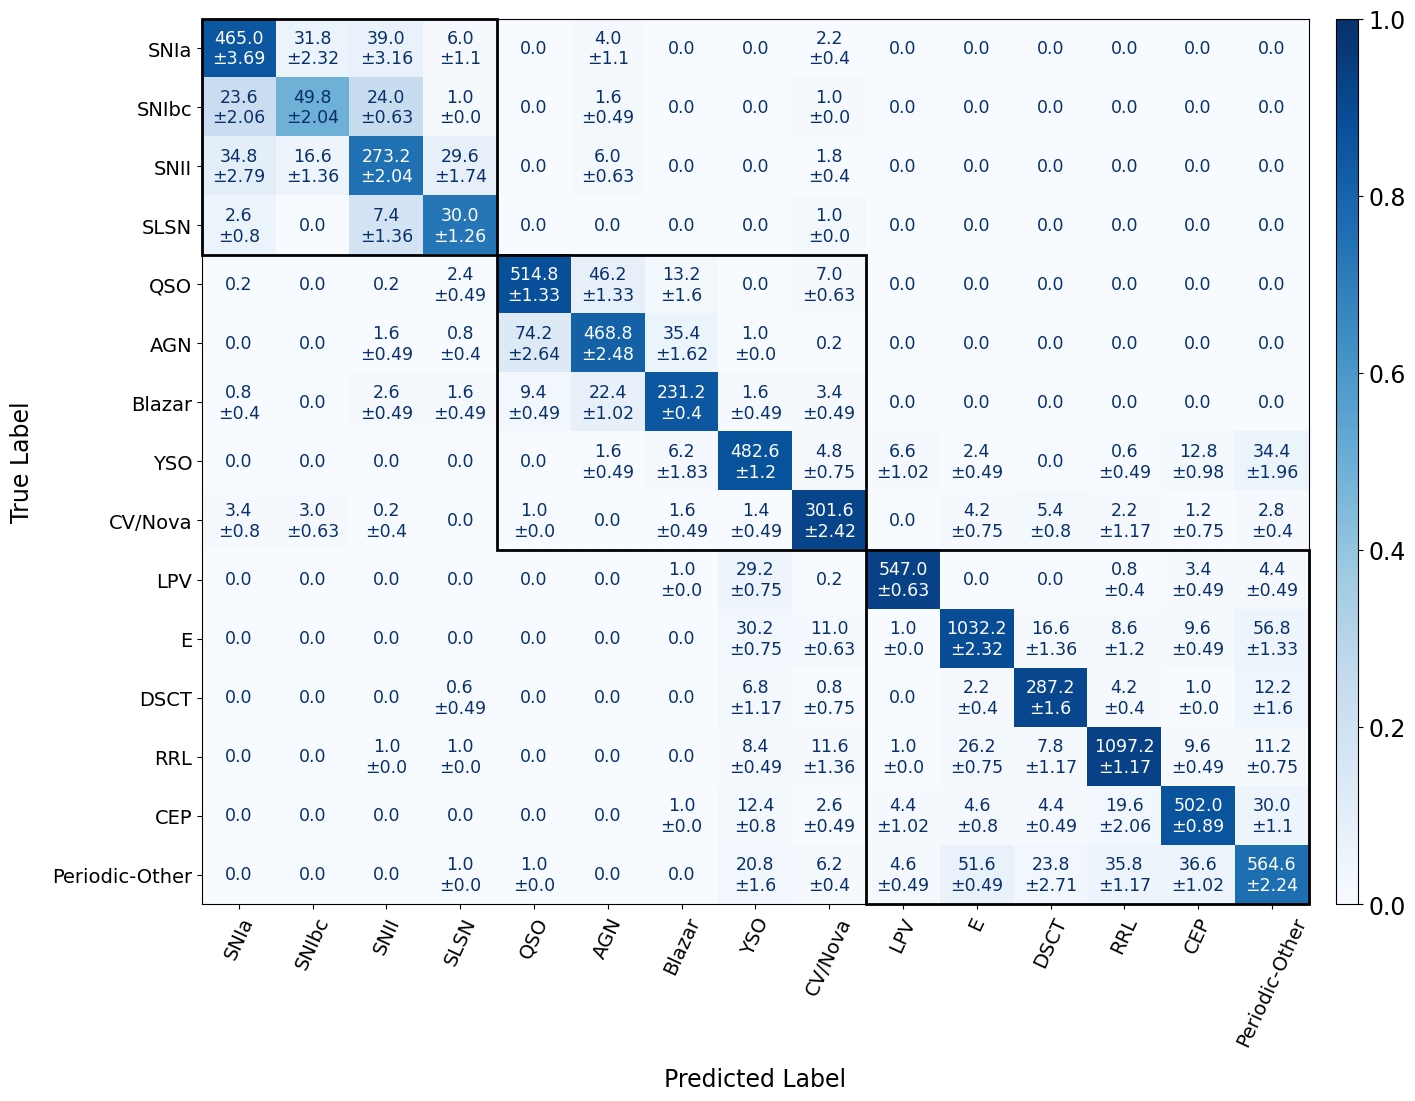

In [51]:
import pandas as pd
from sklearn.metrics import confusion_matrix

matrices = []
matrices_norm = []

num_folds = 5
for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values

    cm = confusion_matrix(y_test, y_pred, labels=order_classes_sanchez_tax)#, normalize='true')
    matrices.append(cm)

    cm_norm = confusion_matrix(y_test, y_pred, labels=order_classes_sanchez_tax, normalize='true')
    matrices_norm.append(cm_norm)

# Calculando la media y la desviación estándar
mean_matrix = np.mean(matrices, axis=0)
std_matrix = np.std(matrices, axis=0)

mean_matrix_norm = np.mean(matrices_norm, axis=0)

path_save = 'cm_hbrf_sanchez_tax_train.pdf'
get_confusion_matrix(mean_matrix, std_matrix, mean_matrix_norm, order_classes_sanchez_tax, class_hierarchy_sanchez_tax, path_save, figsize=(16,11))

In [6]:
from sklearn.metrics import classification_report

# Leer las predicciones y calcular los reportes de métricas
num_folds = 5
report_metrics = []

for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    report_metrics.append(classification_report(y_test, y_pred, output_dict=True))

# Calcular métricas por clase y macro promedio
data = []
for label in order_classes_sanchez_tax + ["Macro Avg"]:
    row = [label]
    for metric in ['precision', 'recall', 'f1-score']:
        values = [report_metrics[i_fold][label if label != "Macro Avg" else 'macro avg'][metric] * 100 for i_fold in range(num_folds)]
        row.append(f"{np.mean(values):.2f} ± {np.std(values):.2f}")
    data.append(row)

# Crear DataFrame con las métricas
df = pd.DataFrame(data, columns=["Class", "Precision", "Recall", "F1-score"]).set_index("Class")
df

,Precision,Recall,F1-score
Class,,,
SNIa,87.68 ± 0.69,84.85 ± 0.67,86.24 ± 0.27
SNIbc,49.23 ± 0.87,49.31 ± 2.02,49.24 ± 1.06
SNII,78.24 ± 0.69,75.47 ± 0.56,76.83 ± 0.40
SLSN,40.59 ± 2.05,73.17 ± 3.09,52.20 ± 2.23
QSO,85.74 ± 0.37,88.15 ± 0.23,86.93 ± 0.25
AGN,85.14 ± 0.51,80.55 ± 0.43,82.78 ± 0.42
Blazar,79.84 ± 0.55,84.69 ± 0.15,82.19 ± 0.32
YSO,81.19 ± 0.46,87.43 ± 0.22,84.19 ± 0.19
CV/Nova,84.86 ± 0.41,91.95 ± 0.74,88.26 ± 0.42
